Imports:

In [1]:
from train_for_real import *
import pickle

c:\Users\mariusz\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mariusz\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\mariusz\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_5m_224 i

In [2]:
from finetuneSAM.cfg import parse_args
#Fine-Tune Sam
args =  parse_args()


# setting if_mask_decoder_adapter = True puts adapters inside 2-way transformer blocks
# this does not change the number of decoder 2-way transformer blocks (def = 2)
# decoder_adapt_depth denotes how many of the two 2-way transformer blocks are adapted


# setting if_encoder_adapter = True puts adapters inside TinyViTBlocks in the encoder
# this does not change the number of encoder TinyViTBlocks (def = 4)
# encoder_adapt_depth (e.g. [1,2]) denotes how deep blocks will be adapted

args.finetune_type = "vanilla"
#args.finetune_type = "adapter"# "vanilla"
#args.if_mask_decoder_adapter = True
#args.image_size = 512
#args.decoder_adapt_depth = 1
args.num_cls = 3


sam = load_model(args)




c:\SamPeft\finetuneSAM\models\sam\build_sam.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [3]:

# # org_data = load_data()

# #save dta as pickle
# with open('data_w_ps.pkl', 'wb') as file:
#     pickle.dump(org_data, file)


with open('data_w_ps.pkl', 'rb') as file:
    org_data = pickle.load(file)

sammy = Sammy(sam, (512,512))
print(len(org_data['image']))


2


In [5]:
org_data = EyeData(org_data)

In [6]:
org_data.divide_into_batches(2)
batch = org_data.batches[0]
batch_imgs = batch['image']
batch_points = batch['points']
batch_p_labels = batch['p_labels']
batch_masks = batch['mask']
features = sammy.encode_img(batch_imgs)
sparse_embeddings, dense_embeddings = sammy.encode_promts(batch_points, batch_p_labels)
iou_predictions, low_res_masks = sammy.decode_features(features, sparse_embeddings, dense_embeddings)






In [ ]:
def visualize_true_mask(mask,points, p_labels):
    f = Upsample(scale_factor=0.5)

    tru = mask
    
    points = points * 0.5
    lbls = p_labels
    

    tru = f(torch.tensor(tru)[None,None, :, :].float()).numpy()
    tru = tru[0][0]
    
    # plot only true mask
    fig, axs = plt.subplots(1, 1, figsize=(10,10))
    axs.imshow(tru, cmap='gray')
    
    #scatter points
    for i in range(len(points)):
        if lbls[i] == 1:
            axs.scatter(points[i][1], points[i][0], c='blue')#, s = 2)
        else:
            axs.scatter(points[i][1], points[i][0], c='red')#, s = 2)

    

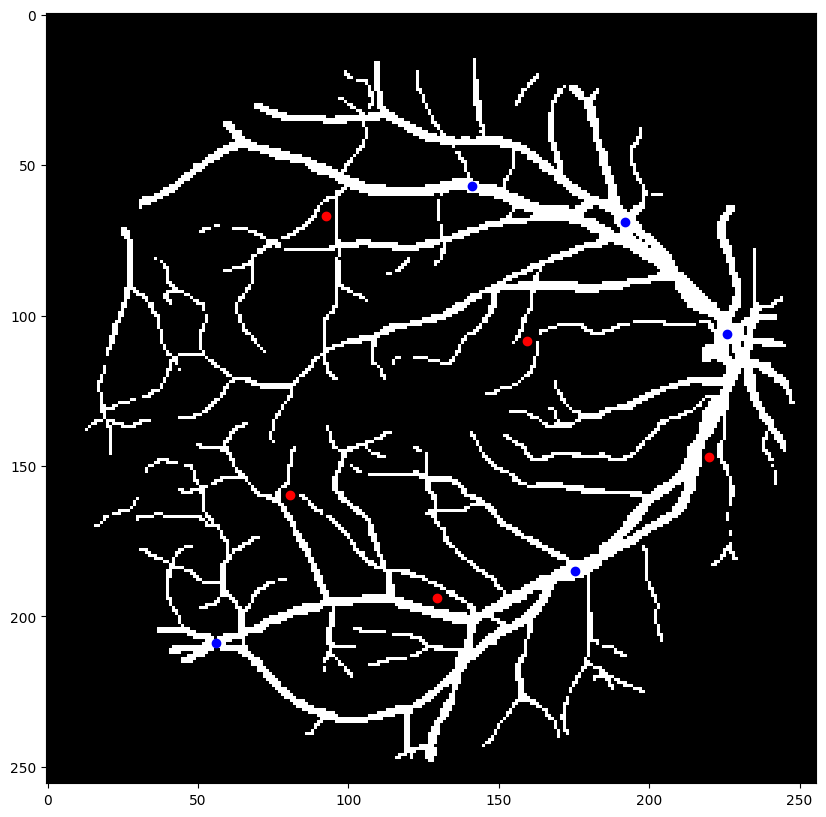

In [ ]:
visualize_true_mask(batch_masks[0], batch_points[0], batch_p_labels[0])

In [8]:

def visualize_predictions(true_mask, low_res_preds, points, p_labels):
    f = Upsample(scale_factor=0.5)
    # tru = org_data['mask'][0]
    # ponts = org_data['points'][0]
    # ponts = ponts * 0.5
    # lbls = org_data['p_labels'][0]

    tru = true_mask
    ponts = points
    ponts = ponts * 0.5
    lbls = p_labels
    

    tru = f(torch.tensor(tru)[None,None, :, :].float()).numpy()
    tru = tru[0][0]
    preds = low_res_masks[0].detach().cpu().numpy()
    preds = np.where(preds > 0.5, 1, 0)
    print(tru.shape)
    print(preds[0].shape)

    # plot three subplots each for tru and a class prediction
    fig, axs = plt.subplots(3,1)
    fig.suptitle('Predictions for Image 1')
    axs[0,].set_title('Prediction 1')
    tNp = tru + preds[0]*5
    axs[0].imshow(tNp)
    # scatter points   
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[0].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[0].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)


    axs[1].set_title('Prediction 2')
    tNp = tru + preds[1]*5
    axs[1].imshow(tNp)
    # scatter points
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[1].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[1].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)


    axs[2].set_title('Prediction 3')
    tNp = tru + preds[2]*5
    axs[2].imshow(tNp)
    # scatter points with size 2pxs
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[2].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[2].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)
    plt.show()






# # 3 masks for 3 classes
# img1_masks = low_res_masks[0]
# # # # plot low res masks
# plt.imshow(img1_masks[].detach().cpu().numpy())
# plt.show()

(256, 256)
(256, 256)


IndexError: index 1 is out of bounds for axis 0 with size 1

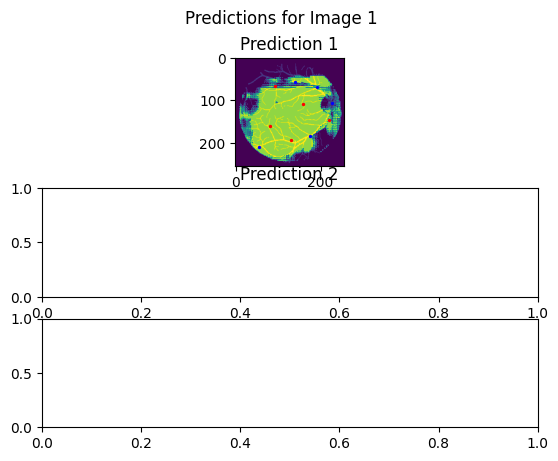

In [9]:
visualize_predictions(batch_masks[0], low_res_masks[0], batch_points[0], batch_p_labels[0])

In [5]:
# #Scientific computing 
# import numpy as np
# #Pytorch packages
# import torch
from torch import nn
import torch.optim as optim
from tensorboardX import SummaryWriter
#Visulization
from tqdm import tqdm
import monai


In [7]:
from finetuneSAM.utils.dsc import dice_coeff_multi_class

sam = sam
with open('data_w_ps.pkl', 'rb') as file:
    data = pickle.load(file)

train_points = len(data['image'])
checkpoints_path = 'checkpoints'


val_percentage = 0.15
val_points = int(train_points*val_percentage)
train_points = train_points - val_points
print('Train points:',train_points)

val_data = {"image":[],"mask":[],"points":[],"p_labels":[]}
for i in range(val_points):
    rnd_indx = np.random.randint(0,len(data["image"])-1)
    val_data["image"].append(data["image"].pop(rnd_indx))
    val_data["mask"].append(data["mask"].pop(rnd_indx))
    val_data['points'].append(data['points'].pop(rnd_indx))
    val_data['p_labels'].append(data['p_labels'].pop(rnd_indx))
    
train_data = data

train_data = EyeData(train_data)

val_data = EyeData(val_data)
    

if args.finetune_type == 'adapter':
    for n, value in sam.named_parameters():
        if "Adapter" not in n: # only update parameters in adapter
            value.requires_grad = False
    print('if update encoder:',args.if_update_encoder)
    print('if image encoder adapter:',args.if_encoder_adapter)
    print('if mask decoder adapter:',args.if_mask_decoder_adapter)
    if args.if_encoder_adapter:
        print('added adapter layers:',args.encoder_adapter_depths)
    
# elif args.finetune_type == 'vanilla' and args.if_update_encoder==False:   
#     print('if update encoder:',args.if_update_encoder)
#     for n, value in sam.image_encoder.named_parameters():
#         value.requires_grad = False
# elif args.finetune_type == 'lora':
#     print('if update encoder:',args.if_update_encoder)
#     print('if image encoder lora:',args.if_encoder_lora_layer)
#     print('if mask decoder lora:',args.if_decoder_lora_layer)
#     sam = LoRA_Sam(args,sam,r=4).sam
sam.to('cuda')
b_lr = args.lr
epochs = 32
batch_size = 2

b_lr = 1e-3
optimizer = optim.AdamW(sam.parameters(), lr=b_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #learning rate decay
criterion1 = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, to_onehot_y=True,reduction='mean')
criterion2 = nn.CrossEntropyLoss()
iter_num = 0
max_iterations = epochs * train_points
writer = SummaryWriter(checkpoints_path + '/log')

pbar = tqdm(range(epochs))
val_largest_dsc = 0
last_update_epoch = 0
print('Start training')

mask_downscale_f = Upsample(scale_factor=0.5)

for epoch in pbar:
    print('Epoch num {}'.format(epoch))
    sam.train()
    train_loss = 0
    train_data.divide_into_batches(batch_size)
    for i in range(len(train_data.batches)):
        batch = train_data.batches[i]
        imgs = batch['image']
        msks = batch['mask']
        points = batch['points']
        labels = batch['p_labels']


        if args.if_update_encoder:
            #img_emb = sam.image_encoder(imgs)
            img_emb = sammy.encode_img(imgs)
        else:
            with torch.no_grad():
                #img_emb = sam.image_encoder(imgs)
                img_emb = sammy.encode_img(imgs)
        
        sparse_emb, dense_emb = sammy.encode_promts(points=points, labels=labels)
        _,pred = sammy.decode_features(img_emb, sparse_emb, dense_emb)


        print('pred shape:',pred.shape)
        print('msks shape:',msks.shape)
        msks_t = torch.tensor(msks).float().cuda()
        msks_t_down = mask_downscale_f(msks_t[None,:,:,:]).long()[0]
        
        
        print('msks downscaled shape:',msks.shape)
        pred_t = pred.argmax(dim=1)
        
        print('pred_t shape:',pred_t.shape)
        print('msks_t_down shape:',msks_t_down.shape)

        loss_dice =  1 - dice_coeff_multi_class(pred_t, msks_t_down,2)
        loss_ce = criterion2(pred,msks_t_down)
        loss =  loss_dice + loss_ce

        # print(' dice loss:',loss_dice)
        # print(' ce loss:',loss_ce)
        
        # throw exception if loss is nan
        if True:
            raise ValueError('loss is nan')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        
        if args.if_warmup and iter_num < args.warmup_period:
            lr_ = args.lr * ((iter_num + 1) / args.warmup_period)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_

        else:
            if args.if_warmup:
                shift_iter = iter_num - args.warmup_period
                assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
                lr_ = args.lr * (1.0 - shift_iter / max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_
            else:
                lr_ = args.lr

        train_loss += loss.item()
        iter_num+=1
        writer.add_scalar('info/lr', lr_, iter_num)
        writer.add_scalar('info/total_loss', loss, iter_num)
        writer.add_scalar('info/loss_ce', loss_ce, iter_num)
        #writer.add_scalar('info/loss_dice', loss_dice, iter_num)

    train_loss /= (i+1)
    pbar.set_description('Epoch num {}| train loss {} \n'.format(epoch,train_loss))

    if epoch%2==0:
        
        eval_loss=0
        dsc = 0
        sam.eval()
        with torch.no_grad():
            for i in range(val_points):
                #print('Validation point num {}'.format(i))
                imgs = val_data['image'][i]
                msks = val_data['mask'][i]
                sammy.set_image(imgs)

                        #img_emb = sam.image_encoder(imgs)
                img_emb = sammy.encode_img()
                
                sparse_emb, dense_emb = sammy.encode_promts(data['t_points'][i], data['bg_points'][i])
                
                pred, _,_ = sammy.decode_features(img_emb, sparse_emb, dense_emb)
                
                msks_t = torch.tensor([msks])
                msks_t = torch.squeeze(msks_t.long(),1).cuda()
                pred_t = pred.argmax(dim=1)
                loss_dice =  1 - dice_coeff_multi_class(pred_t, msks_t,2)
                loss_ce = criterion2(pred,torch.tensor([msks]).long().cuda())
                loss = loss_dice + loss_ce
                
                eval_loss +=loss.item()
                dsc_batch = dice_coeff_multi_class(pred_t, msks_t,2)
                dsc+=dsc_batch
                #print(dsc_batch)

            eval_loss /= (i+1)
            dsc /= (i+1)
            
            writer.add_scalar('eval/loss', eval_loss, epoch)
            writer.add_scalar('eval/dice', dsc, epoch)
            
            print('Eval Epoch num {} | val loss {} | dsc {} \n'.format(epoch,eval_loss,dsc))
            if dsc>val_largest_dsc:
                val_largest_dsc = dsc
                last_update_epoch = epoch
                print('largest DSC now: {}'.format(dsc))
                torch.save(sam.state_dict(),checkpoints_path + '/checkpoint_best.pth')
            elif (epoch-last_update_epoch)>20:
                # the network haven't been updated for 20 epochs
                print('Training finished###########')
                break
writer.close()

Train points: 2


  0%|          | 0/32 [00:00<?, ?it/s]

Start training
Epoch num 0


  0%|          | 0/32 [00:07<?, ?it/s]

pred shape: torch.Size([2, 1, 256, 256])
msks shape: (2, 512, 512)
msks downscaled shape: (2, 512, 512)
pred_t shape: torch.Size([2, 256, 256])
msks_t_down shape: torch.Size([2, 256, 256])


ValueError: loss is nan

In [ ]:
criterion2 = nn.CrossEntropyLoss()


In [60]:
c  = nn.BCEWithLogitsLoss()
input = np.ones((15,512,512))*(-10)
tru = np.ones((15,512,512))
#criterion2(torch.tensor(input),torch.tensor(tru).long())
a =torch.tensor(input).float()
b = torch.tensor(tru).float()
c(a,b)

tensor(10.0000)

In [48]:
input = np.zeros((15,512,512))
tru = np.ones((15,512,512))
#criterion2(torch.tensor(input),torch.tensor(tru).long())
a =torch.tensor(input).float()
b = torch.tensor(tru).float()
dice_coeff_multi_class(a,b,1)

tensor(3.8147e-06)

In [73]:
import monai.losses


m = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, to_onehot_y=True,reduction='mean')
input = np.ones((15,1,512,512))*10*(-1)
tru = np.ones((15,1,512,512))
#criterion2(torch.tensor(input),torch.tensor(tru).long())
a =torch.tensor(input).float()
b = torch.tensor(tru).float()
m(a,b)

c:\Users\mariusz\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\losses\dice.py:156: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


tensor(0.9999)

In [80]:

input = np.zeros((15,1,512,512))
input = torch.squeeze(torch.tensor(input))
input = torch.unsqueeze(torch.tensor(input),1)
input.shape


C:\Users\mariusz\AppData\Local\Temp\ipykernel_18932\790036749.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.unsqueeze(torch.tensor(input),1)


torch.Size([15, 1, 512, 512])